In [1]:
import os, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src import dataio, visualize

In [2]:
# データセットの読み込み
df_train, images_train = dataio.read_data('../dataset/train')
df_test, images_test = dataio.read_data('../dataset/test')

100%|██████████| 10000/10000 [00:01<00:00, 6321.87it/s]


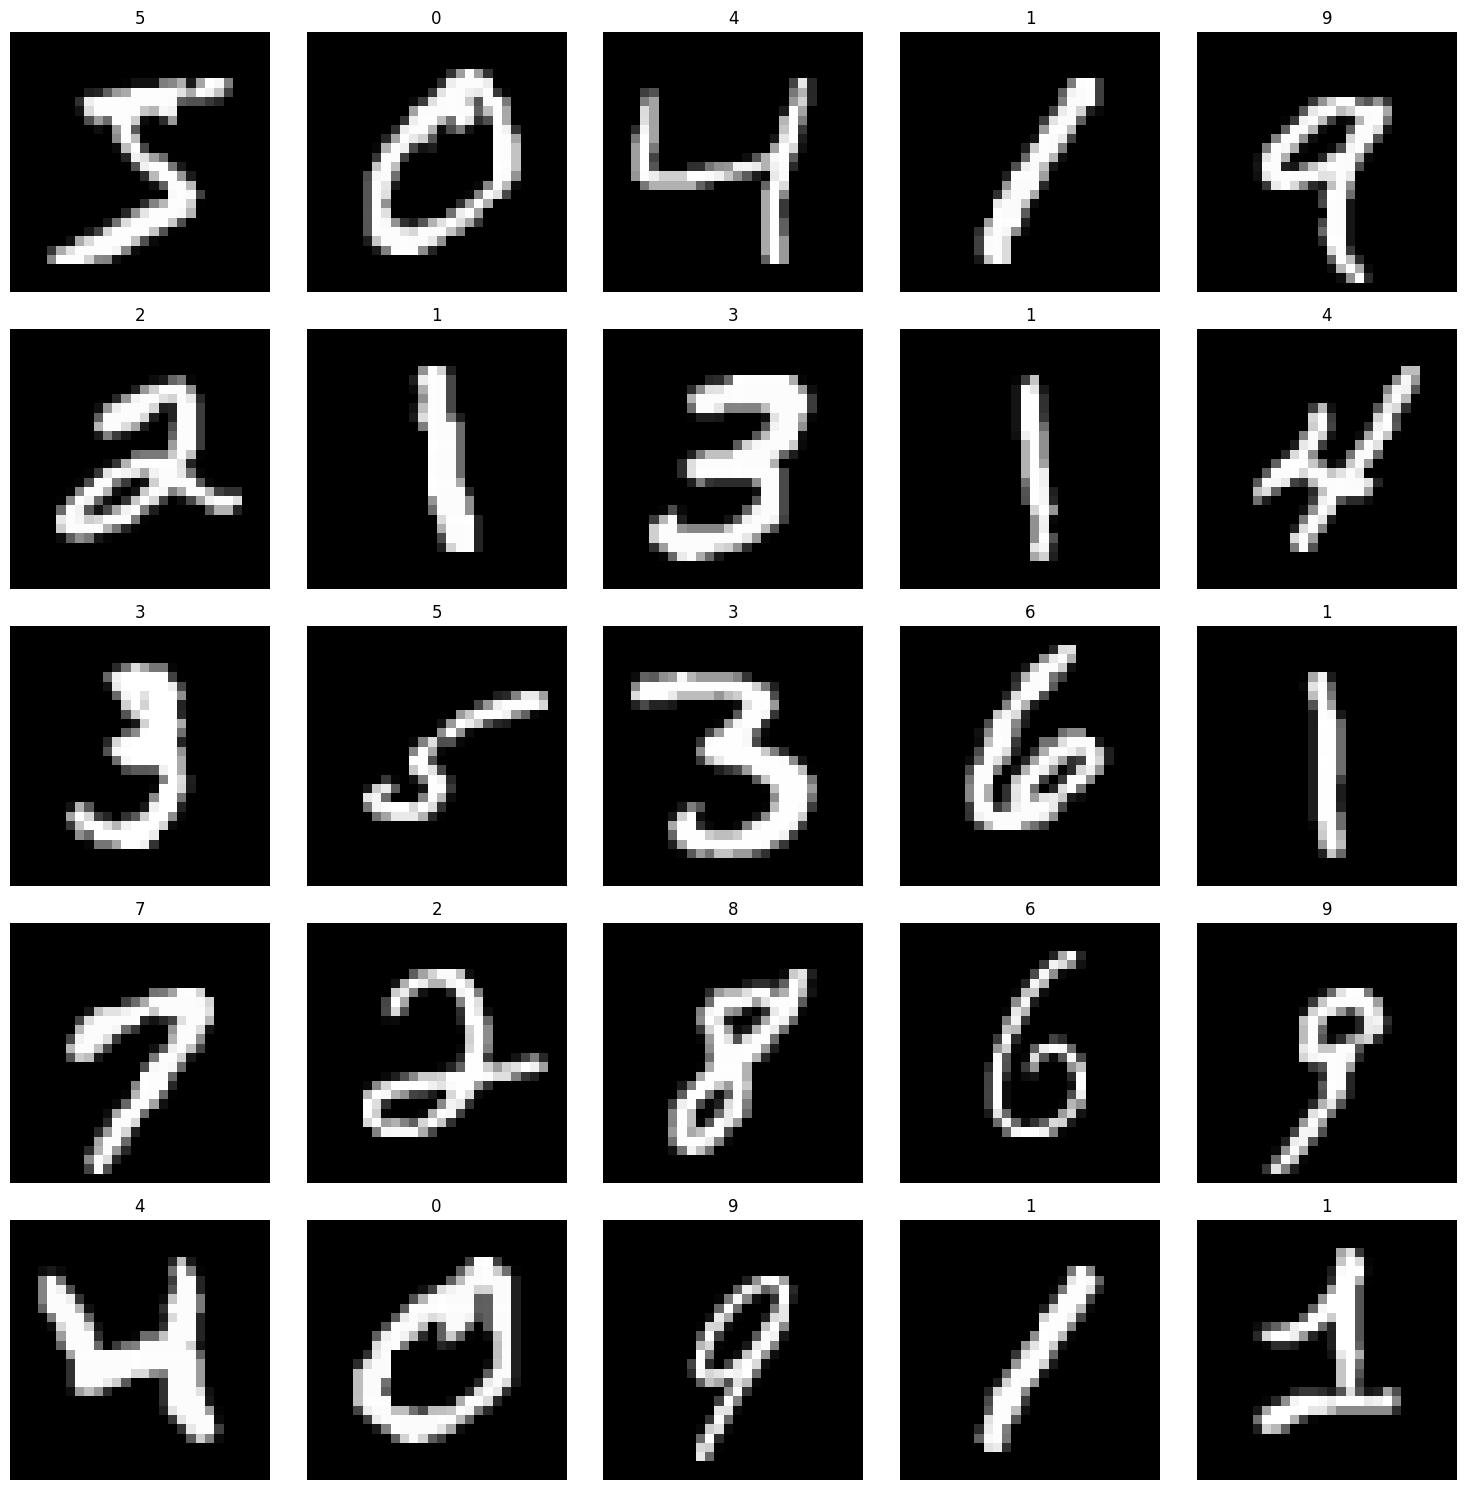

In [3]:
visualize.plot_images(images_train[:25], df_train, ncols=5, figsize=(15, 15))

In [4]:
# 画像の形状を確認
images_train.shape

(60000, 28, 28)

In [9]:
def preprocessing(image: np.ndarray, mean: np.ndarray | None = None, std: np.ndarray | None = None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """画像の前処理を行う関数

    Parameters
    ----------
    image : np.ndarray
        前処理する画像
    mean : np.ndarray
        平均値
    std : np.ndarray
        標準偏差

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray]
        前処理後の画像、平均値、標準偏差
    """
    # 0-1に正規化
    image = image.astype(np.float32)
    image /= 255.0
    
    if mean is None:
        mean = np.mean(image)
    if std is None:
        std = np.std(image)

    return (image - mean) / std, mean, std

In [10]:
images_train_preprocessed, mean, std = preprocessing(images_train)
images_test_preprocessed, _, _ = preprocessing(images_test, mean, std)

In [11]:
# ロジスティック回帰の学習
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=100, penalty='l1', solver='saga', n_jobs=8, random_state=42)
model.fit(images_train_preprocessed.reshape(len(images_train), -1), df_train["label"])

/Users/junnosuke.kado/Documents/00_projects/2507_SIAI/sandbox_kado/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'saga'
,max_iter,100
,multi_class,'deprecated'


In [12]:
model.score(images_train_preprocessed.reshape(len(images_train), -1), df_train["label"])

0.9391333333333334

In [13]:
model.score(images_test_preprocessed.reshape(len(images_test), -1), df_test["label"])

0.9266

In [14]:
with open("logistic.pkl", "wb") as f:
    import pickle
    pickle.dump(model, f)

In [15]:
model.intercept_

array([-0.21134321, -0.30001882,  0.30744666,  0.28931803, -0.3221183 ,
        0.32571796, -0.02517807, -0.04763662,  0.17925271, -0.20327231],
      dtype=float32)

In [16]:
np.mean(np.exp(images_train_preprocessed.reshape(len(images_train), -1) @ model.coef_.T + model.intercept_).argmax(axis=1) == df_train["label"].values)

0.9391333333333334

In [17]:
np.mean(np.exp(images_test_preprocessed.reshape(len(images_test_preprocessed), -1) @ model.coef_.T + model.intercept_).argmax(axis=1) == df_test["label"].values)

0.9266

In [18]:
model_dict = {
    'mean': mean,
    'std': std,
    'weights': model.coef_,
    'intercept': model.intercept_
}
with open("logistic_dict.pkl", "wb") as f:
    import pickle
    pickle.dump(model_dict, f)

In [19]:
np.exp(images_test_preprocessed.reshape(len(images_test_preprocessed), -1) @ model.coef_.T + model.intercept_).argmax(axis=1) 

array([7, 2, 1, ..., 4, 5, 6])

In [20]:
mean, std

(0.13066062, 0.30810776)

(array([1005., 1154., 1001., 1020.,  981.,  866.,  966., 1022.,  974.,
        1011.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

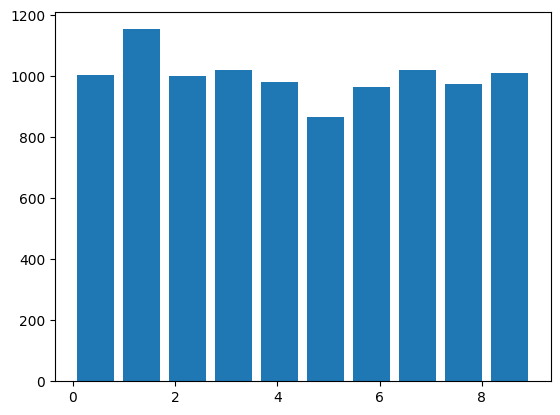

In [21]:
plt.hist(np.exp(images_test_preprocessed.reshape(len(images_test_preprocessed), -1) @ model.coef_.T + model.intercept_).argmax(axis=1) , bins=10, range=(0, 9), rwidth=0.8)

In [22]:
images_test_preprocessed[10, :, 10]

array([-0.42407444, -0.42407444, -0.42407444, -0.42407444, -0.42407444,
        1.8542218 ,  2.8088155 ,  2.8088155 ,  2.7960873 ,  1.5869358 ,
        0.88690054,  0.3141445 , -0.42407444, -0.42407444, -0.42407444,
       -0.42407444, -0.42407444, -0.42407444, -0.42407444, -0.42407444,
       -0.42407444,  1.8669499 ,  2.8088155 ,  2.8088155 , -0.42407444,
       -0.42407444, -0.42407444, -0.42407444], dtype=float32)

In [25]:
mean, std

(0.13066062, 0.30810776)